# Ragas Evaluation

Ragas is a framework that helps you evaluate your Retrieval Augmented Generation (RAG) pipelines. It provides several modules which come handy for evaluating RAG. The two main ones - and the ones we are using in this guide are:

- *TestsetGenerator*: This module is responsible for generating test sets for evaluating RAG pipelines. It loads a bunch of documents or text chunks and then uses an LLM to generate potential questions based on these documents as well as answers for these questions - based on the provided documents. The generated answers are then used as "ground truth" to evaluate the RAG pipeline in a subsequent step.

- *evaluate*: This module is responsible for evaluating RAG pipelines using the generated test sets. uses the questions of the generated test set to evaluate the RAG pipeline. It again uses an LLM to validate the answers given from your RAG pipeline based on the questions provided in the test set. The LLM also is asked to validate how good the provided contexts fit the questions. And finally, the LLM answer is compared to the ground truth answer (which is part of the test set) to evaluate the LLM itself. It provides a variety of evaluation metrics, including answer relevancy, faithfulness, context recall, and context precision

In [1]:
# LIBRARIES IMPORT
import numpy as np
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from ragas import adapt
from ragas import evaluate
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context, conditional
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from datasets import Dataset
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


In [2]:
# MODULES IMPORT
from query_chatbot import load_database
from query_chatbot import generate_answer, search_similarity_in_database

## Tooling


In [3]:
# Function to load the database of vectors
def load_database_from_path(vector_db_path: str) -> Chroma:
    """ Load the database of vectors from a given path """
    # Load the database
    vector_db = load_database(vector_db_path)[0]

    return vector_db

In [4]:
# Function to reconstruct the chunks from the vector database
def reconstruct_chunks(vector_db: Chroma) -> list:
    """Reconstruct the chunks from the vector database.
    Parameters
    ----------
    vector_db : Chroma
        The vector database to reconstruct the chunks.
    Returns
    -------
    chunks : list of Document
        List of text chunks reconstructed from the vector database.
        format : [{"page_content": str, "metadata": dict}, ...]
    """
    chunks = []
    vector_collections = vector_db.get()
    total_chunks = len(vector_collections["ids"])
    for i in range(total_chunks):
        chunk = {
            "page_content": vector_collections["documents"][i],
            "metadata": vector_collections["metadatas"][i],
        }
        # ** used to unpack a dictionary into keyword arguments.
        chunk = Document(**chunk)
        chunks.append(chunk)

    print(
        f"Reconstructed {total_chunks} chunks from the vector database successfully.\n"
    )

    return chunks

In [5]:
# Function to create the testset
def create_testset(chunks: list, generator_llm_name: str, critic_llm_name: str, language: str) -> DataFrame:
    """Create the testset for the evaluation.
    
    Parameters
    ----------
    chunks : list of Document
        List of text chunks to generate the testset.
    generator_llm_name : str
        The name of the generator language model for simple questions.
    critic_llm_name : str
        The name of the critic language model for reasoning questions.
    language : str
        The language of the testset.
    
    Returns
    -------
    testset : DataFrame
        The generated testset.
    """
    # Create the generator from openai models
    generator_llm = ChatOpenAI(model=generator_llm_name)
    critic_llm = ChatOpenAI(model= critic_llm_name)
    embeddings = OpenAIEmbeddings()

    # Define the testset generator
    generator = TestsetGenerator.from_langchain(generator_llm, critic_llm, embeddings)
    # adapt the generator to the French language
    generator.adapt(language, evolutions=[simple, reasoning,conditional,multi_context])
    # save the generator
    generator.save(evolutions=[simple, reasoning, multi_context,conditional])

    # Generate the testset
    testset = generator.generate_with_langchain_docs(
        chunks, # chunks to generate the testset
        test_size=10, # number of samples to generate
        distributions={simple: 0.4, reasoning: 0.2, multi_context: 0.2, conditional: 0.2} # distribution of the testset for each type of question
    )
    # convert the testset to a dataframe
    testset_df = testset_df = testset.to_pandas()

    return testset_df   

In [6]:
# Function to get the answers from the rag pipeline
def get_answers(testset_df: DataFrame, vector_db: Chroma, llm_name: str) -> DataFrame:
    """Get the answers from the RAG pipeline.

    Parameters
    ----------
    testset_df : DataFrame
        The testset dataframe.
    vector_db : Chroma
        The vector database.
    llm_name : str
        The name of the language model to use for the answer generation.

    Returns
    -------
    dataset : DataFrame
        The dataset containing the questions, answers, contexts, and ground truth.
    """
    # Create list of questions and ground truth
    questions = testset_df["question"].to_list()
    ground_truth = testset_df["ground_truth"].to_list()

    # Initialize the data dictionary
    data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

    # Generate answers for the questions and store query, answer, and relevant contexts in the data dictionary
    for query in questions:
        relevant_chunks = search_similarity_in_database(vector_db, query, 3)
        answer = generate_answer(query, "", relevant_chunks, llm_name)
        data["question"].append(query)
        data["answer"].append(answer)
        data["contexts"].append([doc.page_content for doc in relevant_chunks])

    # Create a dataset from the data dictionary
    dataset = Dataset.from_dict(data)
    # Convert the dataset to pandas dataframe
    dataset.to_pandas()

    return dataset

In [7]:
# Function to evaluate the answers
def evaluate_answers(dataset: DataFrame, metrics) -> dict:
    """Evaluate the answers using the RAG evaluation metrics.
    
    Parameters
    ----------
    dataset : DataFrame
        The dataset containing the questions, answers, contexts, and ground truth.
    metrics : list
        The list of evaluation metrics to use.
    
    Returns
    -------
    results : dict
        The evaluation results.
    """
    # Evaluate the dataset
    evaluation = evaluate(
        dataset = dataset,
        metrics = metrics
    )
    print(f"For the testset, the evaluation results are as follows:\n")
    print(evaluation)

    evaluation_df = evaluation.to_pandas()

    return evaluation_df

In [8]:
# Function to plot the evaluation results
def plot_evaluation_results(evaluation_results: DataFrame, metrics: list):
    """Plot the evaluation results.
    
    Parameters
    ----------
    evaluation_results : DataFrame
        The evaluation results dataframe.
    metrics : list
        The list of evaluation metrics to plot.
    """
    # Create a heatmap of the evaluation results
    heatmap_data = evaluation_results[metrics]
    # Gradient color map
    cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)
    plt.yticks(ticks=range(len(evaluation_results['question'])), labels=evaluation_results['question'], rotation=0)

    plt.show()

## Exploratory Data Analysis


### Load data

In [9]:
# Load Chroma database
vector_db = load_database_from_path("../chroma_db")

2024-06-01 18:31:40.091 | INFO     | query_chatbot:load_database:167 - Loading the vector database.
2024-06-01 18:31:41.101 | INFO     | query_chatbot:load_database:177 - Chunks in the database: 1312
2024-06-01 18:31:41.102 | SUCCESS  | query_chatbot:load_database:179 - Vector database prepared successfully.



In [10]:
# Get the chunks
chunks = reconstruct_chunks(vector_db)
# Get 50 samples from the chunks randomly
random_50_chunks = np.random.choice(chunks, 50, replace=False)

Reconstructed 1312 chunks from the vector database successfully.



### Create the test set

In [11]:
testset_df = create_testset(chunks=random_50_chunks, generator_llm_name="gpt-3.5-turbo", critic_llm_name="gpt-4o", language="fr")

embedding nodes:   0%|          | 0/100 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
testset_df

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,Quel est le rôle d'un PanedWindow dans la créa...,[- *Toplevel* : pour créer des fenêtres indépe...,Le PanedWindow est un conteneur pour d'autres ...,simple,[{'chapter_name': '20 Fenêtres graphiques et *...,True
1,How can you access elements in a pandas series...,[### 17.4.1 *Series* \nLe premier type de don...,You can access elements in a pandas series usi...,simple,[{'chapter_name': '17 Quelques modules d'intér...,True
2,Quelle erreur est renvoyée si on mélange des e...,"[Nous avions déjà croisé `min()`, `max()` dans...",TypeError: '<' not supported between instances...,simple,"[{'chapter_name': '4 Listes', 'file_name': '04...",True
3,Quel conseil est donné aux débutants concernan...,[## 3.4 Ancienne méthode de formatage des chaî...,"Pour les débutants, tout ce qui est écrit dans...",simple,"[{'chapter_name': '3 Affichage', 'file_name': ...",True
4,Comment fonctionne la méthode .items() dans le...,"[```python\n>>> dico = {""pinson"": 2, ""merle"": ...",La méthode .items() dans les dictionnaires Pyt...,reasoning,"[{'chapter_name': '13 Containers, dictionnaire...",True
5,Comment l'interface graphique utilisateur (GUI...,[\nAu delà de l'aspect convivial pour l'utilis...,Une interface graphique utilisateur (GUI) basé...,reasoning,[{'chapter_name': '20 Fenêtres graphiques et *...,True
6,Quelle est la différence entre une référence e...,[## 11.4 Copie de listes \nIl est très import...,"Lors de l'affectation d'une liste en Python, c...",multi_context,"[{'chapter_name': '11 Plus sur les listes', 'f...",True
7,Quel est le mécanisme de redéfinition utilisé ...,"[open-box-rem \nÀ ce point, nous pouvons fair...",Python utilise le mécanisme de redéfinition de...,multi_context,[{'chapter_name': '19 Avoir la classe avec les...,True
8,How can elements be retrieved from a pandas Se...,[### 17.4.1 *Series* \nLe premier type de don...,Les éléments d'une série pandas peuvent être r...,conditional,[{'chapter_name': '17 Quelques modules d'intér...,True
9,Quelle fonction de NumPy génère une matrice di...,"[>>> a = np.diag((1, 2, 3))\n>>> a\narray([[1,...",La fonction de NumPy qui génère une matrice di...,conditional,[{'chapter_name': '17 Quelques modules d'intér...,True


### Get the answers from the RAG pipeline

In [12]:
answers_dataset = get_answers(testset_df, vector_db, llm_name="gpt-4o")

2024-06-01 18:34:03.531 | INFO     | query_chatbot:search_similarity_in_database:208 - Searching for relevant documents in the database.
2024-06-01 18:34:04.523 | INFO     | query_chatbot:search_similarity_in_database:220 - Chunk ID: 529
2024-06-01 18:34:04.524 | INFO     | query_chatbot:search_similarity_in_database:221 - Number of tokens: 50
2024-06-01 18:34:04.524 | INFO     | query_chatbot:search_similarity_in_database:222 - Content: - *Toplevel* : pour ...
2024-06-01 18:34:04.526 | INFO     | query_chatbot:search_similarity_in_database:220 - Chunk ID: 528
2024-06-01 18:34:04.528 | INFO     | query_chatbot:search_similarity_in_database:221 - Number of tokens: 125
2024-06-01 18:34:04.530 | INFO     | query_chatbot:search_similarity_in_database:222 - Content: - *tkMessageBox* : a...
2024-06-01 18:34:04.532 | INFO     | query_chatbot:search_similarity_in_database:220 - Chunk ID: 554
2024-06-01 18:34:04.533 | INFO     | query_chatbot:search_similarity_in_database:221 - Number of tokens

### Evaluate the model

In [15]:
metrics = [faithfulness, context_precision, context_recall, answer_relevancy]
evaluation_results = evaluate_answers(answers_dataset, metrics)

AttributeError: 'str' object has no attribute 'evaluation_mode'

### Visualize the results


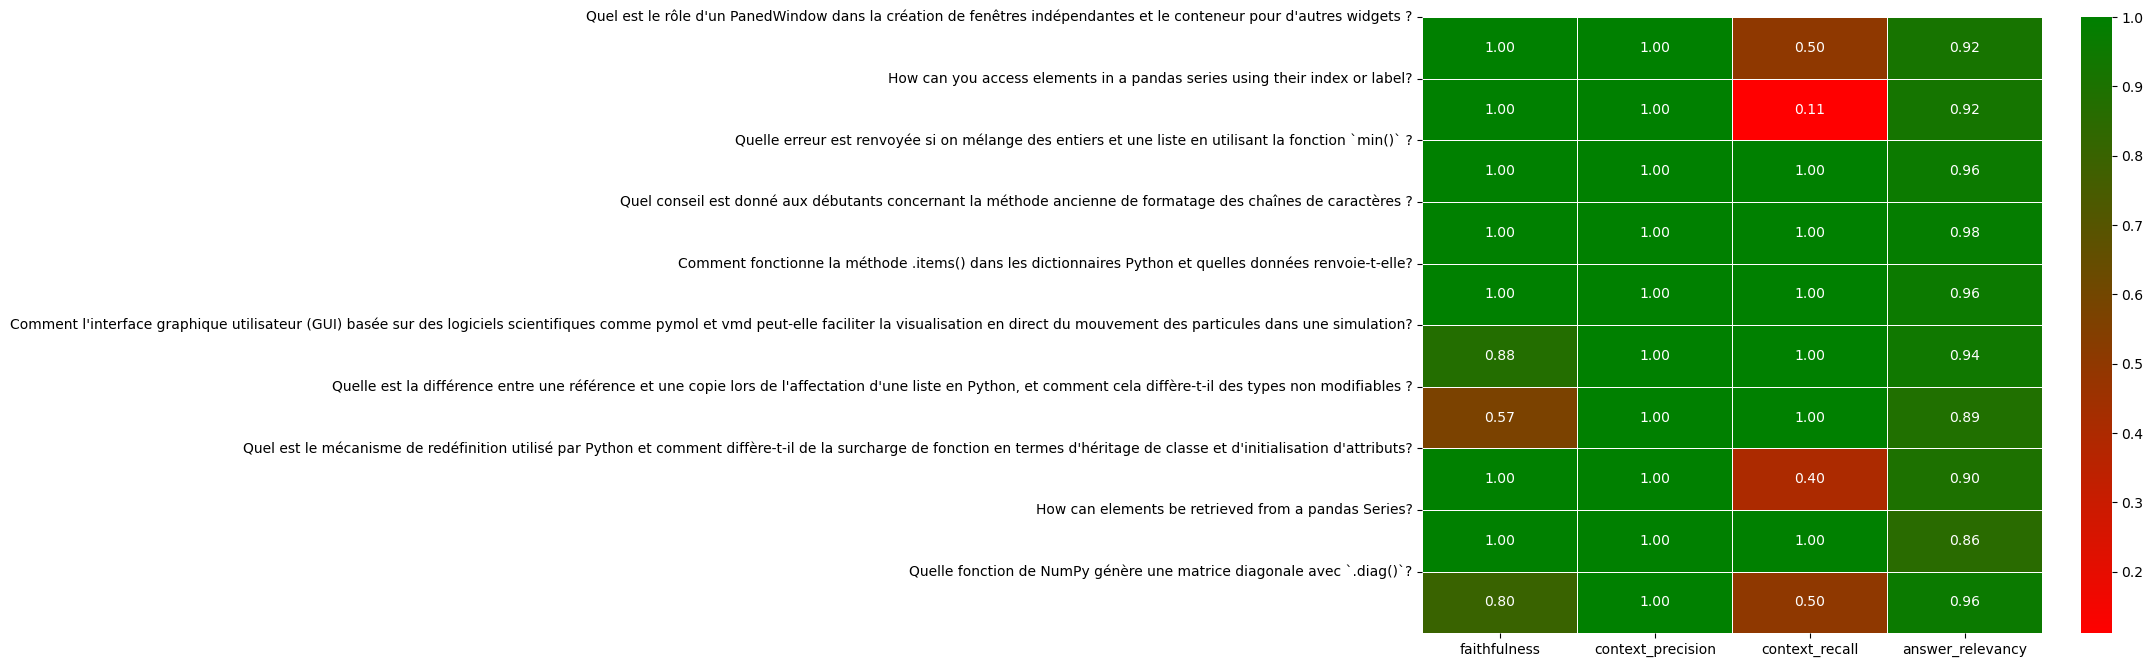

In [16]:
# Define the metrics to plot
metrics_str = [str(metric) for metric in metrics]
plot_evaluation_results(evaluation_results, metrics_str)